In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Conv2D, UpSampling2D, MaxPooling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
import os
import nibabel as nib
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import glob
import skimage.io as io
import skimage.color as color
import random as r
import math
from nilearn import plotting
import warnings
warnings.filterwarnings('ignore')

In [2]:
Flair= nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_flair.nii')
Seg= nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii')
T1= nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t1.nii')
T1ce= nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t1ce.nii')
T2= nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t2.nii')

In [3]:
# Path to the dataset
data_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
patients = os.listdir(data_path)

# Initializing list to hold preprocessed data
processed_data = []

# Function to preprocess the modalities for a single patient
def preprocess_modalities(modality_paths):
    modalities = []
    
    # Loop through each modality file and load it
    for modality in modality_paths:
        # Load the NIfTI file and convert to a NumPy array
        nifti_image = nib.load(modality)
        modality_data = np.asarray(nifti_image.dataobj)
        modalities.append(modality_data)
    
    # Stacking modalities into a single array and transpose to match the expected input shape
    stacked_modalities = np.stack(modalities)
    
    # Converting data to integer type
    stacked_modalities = np.rint(stacked_modalities).astype(np.int16)
    
    # Transposing the stacked array so that dimensions match (H, W, D, Channels)
    stacked_modalities = np.transpose(stacked_modalities, (1, 2, 3, 0))
    
    return stacked_modalities

# Iterate over the first 20 patients and process their data
for patient in patients[:20]:
    patient_dir = os.path.join(data_path, patient)
    
    # Gather all modality file paths
    flair_path = glob.glob(os.path.join(patient_dir, '*_flair*.nii'))[0]
    t1_path = glob.glob(os.path.join(patient_dir, '*_t1*.nii'))[0]
    t1ce_path = glob.glob(os.path.join(patient_dir, '*_t1ce*.nii'))[0]
    t2_path = glob.glob(os.path.join(patient_dir, '*_t2*.nii'))[0]
    ground_truth_path = glob.glob(os.path.join(patient_dir, '*_seg*.nii'))[0]
    
    # Store the paths for the different modalities
    modality_paths = [flair_path, t1_path, t1ce_path, t2_path, ground_truth_path]
    
    # Preprocess and add to the data list
    patient_data = preprocess_modalities(modality_paths)
    processed_data.append(patient_data)

In [4]:
import numpy as np

# Function to concatenate modalities along the 0th axis
def concatenate_modalities(input_data):
    concatenated_modalities = []
    
    # Iterating over each modality (there are 5 modalities per patient)
    for modality_index in range(5):
        print('$')
        concatenated_modality = None
        
        for i in range(0, len(input_data), 2):
            # Extract the modality from each patient
            modality_a = input_data[i][:, :, :, modality_index]
            modality_b = input_data[i + 1][:, :, :, modality_index]
            
            if i == 0:
                concatenated_modality = np.concatenate((modality_a, modality_b), axis=0)
                print('Initial concatenation: {}'.format(concatenated_modality.shape))
            else:
                # Concatenate with the previous concatenated result
                concatenated_pair = np.concatenate((modality_a, modality_b), axis=0)
                concatenated_modality = np.concatenate((concatenated_modality, concatenated_pair), axis=0)
                print('Further concatenation: {}'.format(concatenated_modality.shape))
        
       
        concatenated_modality = concatenated_modality[:, :, :, np.newaxis]
        concatenated_modalities.append(concatenated_modality)
    
    return concatenated_modalities

concatenated_modalities = concatenate_modalities(processed_data)

combined_modalities = np.concatenate(concatenated_modalities, axis=3)

combined_modalities = np.array(combined_modalities, dtype='float32')

t1_modality = np.array(combined_modalities[:, :, :, 1], dtype='float32')
ground_truth_labels = np.array(combined_modalities[:, :, :, 4], dtype='float32')

# Checking the shapes of the arrays
print("Shape of combined_modalities: ", combined_modalities.shape)
print("Shape of t1_modality: ", t1_modality.shape)
print("Shape of ground_truth_labels: ", ground_truth_labels.shape)

$
Initial concatenation: (480, 240, 155)
Further concatenation: (960, 240, 155)
Further concatenation: (1440, 240, 155)
Further concatenation: (1920, 240, 155)
Further concatenation: (2400, 240, 155)
Further concatenation: (2880, 240, 155)
Further concatenation: (3360, 240, 155)
Further concatenation: (3840, 240, 155)
Further concatenation: (4320, 240, 155)
Further concatenation: (4800, 240, 155)
$
Initial concatenation: (480, 240, 155)
Further concatenation: (960, 240, 155)
Further concatenation: (1440, 240, 155)
Further concatenation: (1920, 240, 155)
Further concatenation: (2400, 240, 155)
Further concatenation: (2880, 240, 155)
Further concatenation: (3360, 240, 155)
Further concatenation: (3840, 240, 155)
Further concatenation: (4320, 240, 155)
Further concatenation: (4800, 240, 155)
$
Initial concatenation: (480, 240, 155)
Further concatenation: (960, 240, 155)
Further concatenation: (1440, 240, 155)
Further concatenation: (1920, 240, 155)
Further concatenation: (2400, 240, 155)


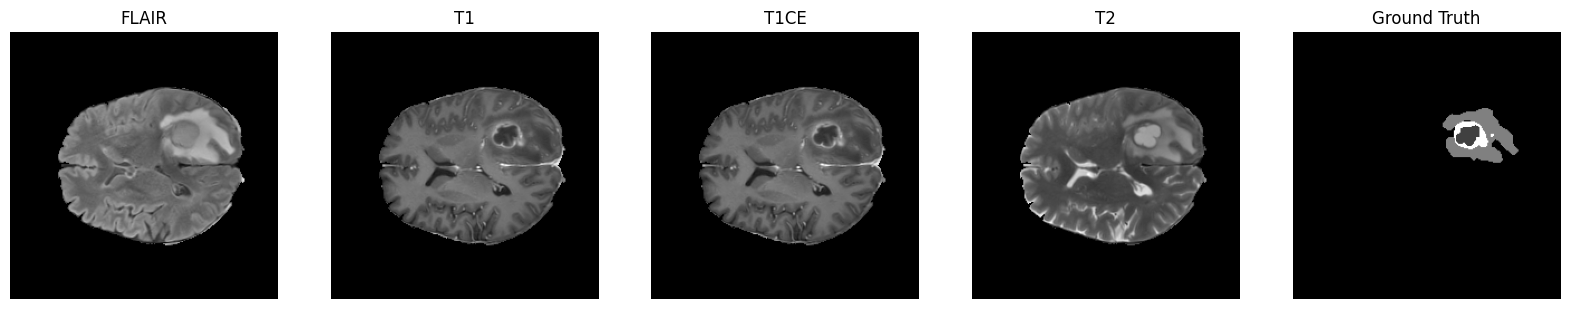

In [5]:
import matplotlib.pyplot as plt

# Function to visualize a slice from different modalities of a patient
def visualize_modalities(patient_data, slice_index):
    modalities = ['FLAIR', 'T1', 'T1CE', 'T2', 'Ground Truth']
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    
    for i in range(5):
        axes[i].imshow(patient_data[:, :, slice_index, i], cmap='gray')
        axes[i].set_title(modalities[i])
        axes[i].axis('off')
    
    plt.show()

selected_patient = processed_data[1]

slice_to_visualize = 80

# Visualize the modalities for the selected patient and slice
visualize_modalities(selected_patient, slice_to_visualize)

In [19]:
from sklearn.model_selection import train_test_split

# 80% Training, 10% Test, 10% Validation Split
# First, split into 90% train and 10% temp (test+validation)
X_train, X_temp, Y_train, Y_temp = train_test_split(t1_modality, ground_truth_labels, test_size=0.20, random_state=42)

X_test, X_val, Y_test, Y_val = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=32)

combined_modalities = 0 

print(f"Training set: X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"Validation set: X_val: {X_val.shape}, Y_val: {Y_val.shape}")
print(f"Test set: X_test: {X_test.shape}, Y_test: {Y_test.shape}")

Training set: X_train: (3840, 240, 155), Y_train: (3840, 240, 155)
Validation set: X_val: (480, 240, 155), Y_val: (480, 240, 155)
Test set: X_test: (480, 240, 155), Y_test: (480, 240, 155)


In [20]:
from skimage.transform import resize
from tensorflow.keras import layers, models

# Resizing images to match model input shape
def resize_images(images, target_size):
    resized_images = []
    for image in images:
        resized_image = resize(image, target_size, mode='reflect', anti_aliasing=True)
        resized_images.append(resized_image)
    return np.array(resized_images)

# Defining Attention U-Net model
def attention_unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottleneck
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    
    # Decoder
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    concat6 = layers.Concatenate()([up6, conv4])
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    concat7 = layers.Concatenate()([up7, conv3])
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    concat8 = layers.Concatenate()([up8, conv2])
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    concat9 = layers.Concatenate()([up9, conv1])
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model

# To Compile and train the model
def compile_and_train_model(model, X_train, Y_train, X_val, Y_val):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=8)
    return history

In [25]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Disabling XLA to avoid XLA warnings
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

input_shape = (128, 128, 1)
attention_unet = attention_unet_model(input_shape)

# Resizing data to match the input shape of the model
X_train_resized = resize_images(X_train, (128, 128, 1))
X_val_resized = resize_images(X_val, (128, 128, 1))
X_test_resized = resize_images(X_test, (128, 128, 1))
Y_train_resized = resize_images(Y_train, (128, 128, 1))
Y_val_resized = resize_images(Y_val, (128, 128, 1))
Y_test_resized = resize_images(Y_test, (128, 128, 1))

history_attention_unet = compile_and_train_model(attention_unet, X_train_resized, Y_train_resized, X_val_resized, Y_val_resized)

Epoch 1/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 71s 130ms/step - accuracy: 0.9690 - loss: 162.7714 - val_accuracy: 0.9851 - val_loss: 0.0808
Epoch 2/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 61s 127ms/step - accuracy: 0.9862 - loss: 0.0774 - val_accuracy: 0.9846 - val_loss: 0.0742
Epoch 3/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 61s 127ms/step - accuracy: 0.9856 - loss: 0.0859 - val_accuracy: 0.9568 - val_loss: 0.3057
Epoch 4/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 61s 126ms/step - accuracy: 0.9779 - loss: 0.3250 - val_accuracy: 0.9853 - val_loss: 0.0669
Epoch 5/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 61s 126ms/step - accuracy: 0.9865 - loss: 0.0674 - val_accuracy: 0.9853 - val_loss: 0.0640
Epoch 6/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 61s 126ms/step - accuracy: 0.9864 - loss: 0.0628 - val_accuracy: 0.9853 - val_loss: 0.0624
Epoch 7/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 61s 126ms/step - accuracy: 0.9863 - loss: 0.0627 - val_accuracy: 0.9853 - val_loss: 0.0610
Epoch 8/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 60s 125ms/step - accuracy: 0.9666 - loss:

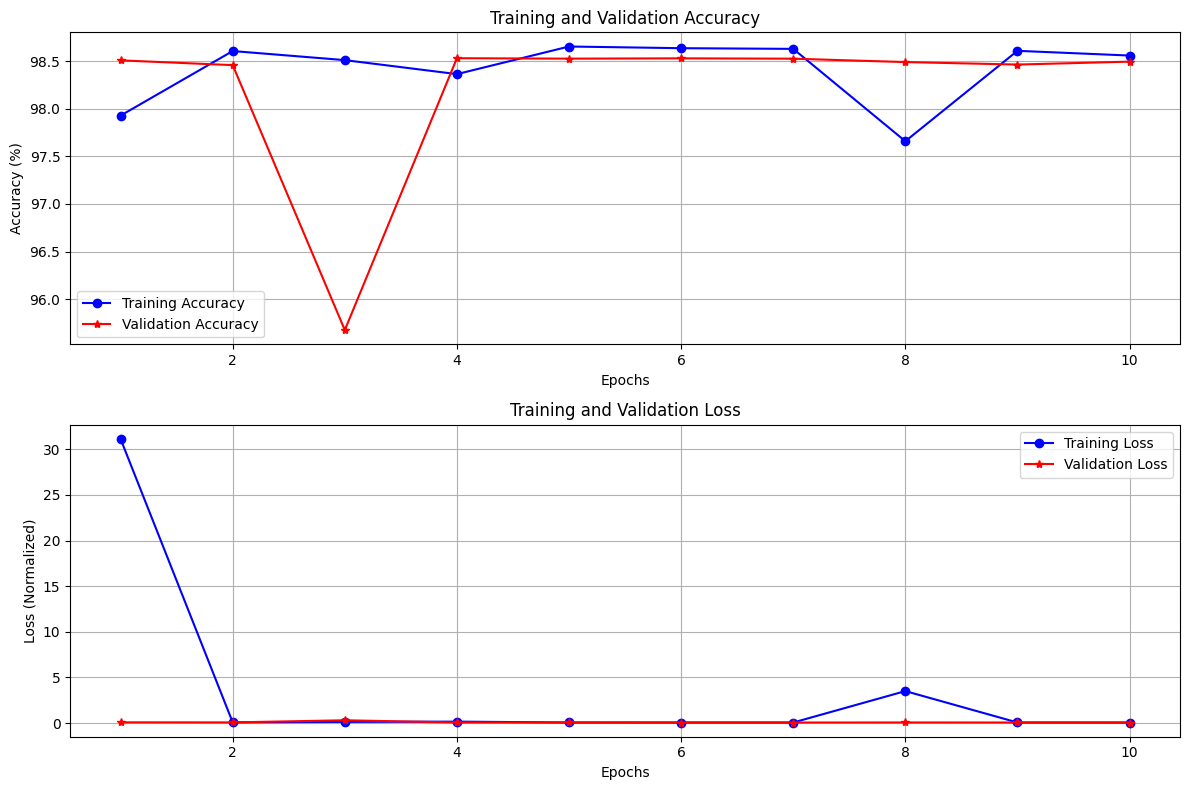

In [27]:
def plot_learning_curves(history):
    # Get training and validation metrics from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Convert accuracy to percentage
    acc = [a * 100 for a in acc]
    val_acc = [a * 100 for a in val_acc]
    
    # Normalize loss values (assuming they are not already between 0 and 1)
    # If you need to scale loss, you could do something like this:
    # min_loss = min(loss + val_loss)  # Find min of both lists
    # max_loss = max(loss + val_loss)  # Find max of both lists
    # loss = [(l - min_loss) / (max_loss - min_loss) for l in loss]
    # val_loss = [(l - min_loss) / (max_loss - min_loss) for l in val_loss]
    
    epochs = range(1, len(acc) + 1)
    
    # Plotting Accuracy
    plt.figure(figsize=(12, 8))  # Make the figure larger
    plt.subplot(2, 1, 1)  # Create subplots (2 rows, 1 column, 1st plot)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # Plotting Loss
    plt.subplot(2, 1, 2)  # 2nd plot in the subplot
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Normalized)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()  # Adjusts spacing to avoid overlap
    plt.show()

# Call the function to plot the learning curves with a larger scale
plot_learning_curves(history_attention_unet)